In [87]:
# importing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import keras
from keras import backend as K
from keras import initializers
from keras.regularizers import l1, l2, l1_l2
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, Dropout, Concatenate, Multiply #Merge
from tensorflow.keras.optimizers import Adam
from time import time

import warnings
warnings.filterwarnings('ignore')

In [88]:
# loading the dataframe
df_main = pd.read_csv('sample30.csv')

### Data Cleaning:

In [89]:
# filtering-in required columns
df_reco = df_main[['name','reviews_username','reviews_rating']]

In [90]:
# check for null values

df_reco.isnull().sum()

name                 0
reviews_username    63
reviews_rating       0
dtype: int64

In [91]:
# dropping rows with NaN values

df_reco.dropna(axis=0, inplace=True)

In [92]:
# check for duplicates

df_reco.duplicated().sum()

2198

In [93]:
# dropping the duplicates

df_reco.drop_duplicates(inplace=True)

In [94]:
# check for duplicates based on subset of 'name' and 'reviews_username'

df_reco.duplicated(subset=['name','reviews_username']).sum()

151

From above we note that we have certain users who have given two or more different ratings to the same products. Let us impute those ratings the average ratings.

In [78]:
# get the average ratings for duplicated rows

df_mean = df_reco[df_reco.duplicated(subset=['name','reviews_username'], keep=False)].groupby(
    by=['name', 'reviews_username']).mean()

df_mean

reviews_rating
name                                               reviews_username                 
100:Complete First Season (blu-Ray)                dontdodat                3.500000
Alex Cross (dvdvideo)                              mookie                   4.500000
Aveeno Baby Continuous Protection Lotion Sunscr... byamazon customer        2.666667
Avery174 Ready Index Contemporary Table Of Cont... gellis                   4.500000
                                                   the office guro          3.500000
...                                                                              ...
Tostitos Bite Size Tortilla Chips                  debb                     4.000000
                                                   rick                     4.500000
                                                   sandy                    3.000000
Windex Original Glass Cleaner Refill 67.6oz (2 ... laura                    1.500000
                                                   suri                     3.500000

[135 rows x 1 columns]

In [79]:
# left merge the df_reco and df_mean dataframes over 'name' and 'reviews_username'

df_merged = df_reco.merge(df_mean, how='left' , on=['name', 'reviews_username']).sort_values(
    by=['name', 'reviews_username'])

df_merged.head()

,name,reviews_username,reviews_rating_x,reviews_rating_y
19543,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,brewno,3,NaN
19545,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,embum,5,NaN
19547,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,granny,5,NaN
19542,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,smokey bear,3,NaN
19546,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,spicesea,5,NaN


In [80]:
df_merged.isnull().sum()

name                    0
reviews_username        0
reviews_rating_x        0
reviews_rating_y    27453
dtype: int64

Since we have very few such rows, we would have many NaN values in reviews_rating_y column. Let us concatenate the dataframe such that we get average values from reviews_rating_y column and normal ratings from reviews_rating_x column

In [81]:
A = df_merged[df_merged['reviews_rating_y'].isnull()][['name','reviews_username','reviews_rating_x']]
A.rename(columns={'reviews_rating_x':'reviews_rating_final'}, inplace=True)

B = df_merged[df_merged['reviews_rating_y'].isnull()==False][['name','reviews_username','reviews_rating_y']]
B.rename(columns={'reviews_rating_y':'reviews_rating_final'}, inplace=True)

df_final= pd.concat([A, B])
df_final.sort_values(by=['name', 'reviews_username'])

,name,reviews_username,reviews_rating_final
19543,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,brewno,3.0
19545,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,embum,5.0
19547,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,granny,5.0
19542,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,smokey bear,3.0
19546,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,spicesea,5.0
...,...,...,...
20525,Yes To Grapefruit Rejuvenating Body Wash,sheila,1.0
20534,Yes To Grapefruit Rejuvenating Body Wash,skeel,4.0
20531,Yes To Grapefruit Rejuvenating Body Wash,td33,3.0
20553,Yes To Grapefruit Rejuvenating Body Wash,trishaxo2u,5.0


In [82]:
# check for duplicates from `df_final` df
df_final.duplicated().sum()

151

In [83]:
# drop duplicates from 'df_final' df

df_final.drop_duplicates(inplace=True)

In [84]:
df_final.head()

,name,reviews_username,reviews_rating_final
19543,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,brewno,3.0
19545,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,embum,5.0
19547,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,granny,5.0
19542,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,smokey bear,3.0
19546,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. ...,spicesea,5.0


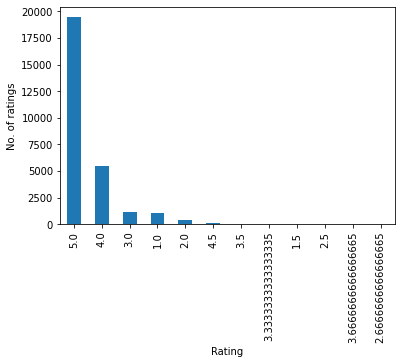

In [85]:
df_final['reviews_rating_final'].value_counts().plot.bar()
plt.xlabel('Rating')
plt.ylabel('No. of ratings')
plt.show()

In [86]:
df_final.duplicated().sum()

0

### Data Preparation:

In [27]:
from sklearn.model_selection import train_test_split

Train, Test = train_test_split(df_final, test_size=0.2, random_state=32)

print(Train.shape)
print(Test.shape)

(22070, 3)
(5518, 3)


We would only be able to test those users and items which are already in our database (Train set). So let's filter-in such common entries and prepare our Test set. 

In [29]:
Test = Test[(Test.name.isin(Train.name)) & (Test.reviews_username.isin(Train.reviews_username))]
print(Test.shape)

(779, 3)


### Matrix Factorization Method:

In [30]:
# Create a user-product matrix.
df_pivot = Train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating_final'
).fillna(0)


R = np.array(df_pivot)
# N: num of User
N = R.shape[0]
# M: num of Movie
M = R.shape[1]
# K: latent features
K = 50

P = np.random.rand(N,K)
Q = np.random.rand(M,K)


In [31]:
def matrix_factorization(R, P, Q, K, steps=50, alpha=0.0002, beta=0.02):
    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    alpha: learning rate
    beta: regularization parameter'''
    
    Q = Q.T

    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # calculate error
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])

                    for k in range(K):
                        # calculate gradient with a and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        eR = np.dot(P,Q)

        e = 0

        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))    # addting L2 regularisation error in the total error
        
        if e < 0.001: # 0.001: local minimum
            break

    return P, Q.T

In [32]:
nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)

In [33]:
# checking predicted ratings with MF method
pred_R = pd.DataFrame(nR, columns = df_pivot.columns, index = df_pivot.index)
pred_R.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",...,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),Stonyfield Yobaby Peach & Pear Yogurt 4oz 6 Ct,"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,8.023277,4.580599,

#### MF Model evaluation:

In [34]:
df_test = Test.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating_final'
).fillna(0)

df_test.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.","Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter","BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Beanitos Bean Chips, Simply Pinto Bean","Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint",Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage",D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,Hollywood Beauty Olive Cholesterol,Home Health Hairever Shampoo,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",...,"Newman's Own Organics Licorice Twist, Black 5oz",Nexxus Exxtra Gel Style Creation Sculptor,"Ogx Conditioner, Hydrating Teatree Mint",Olay Regenerist Deep Hydration Regenerating Cream,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack","Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl",Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201",Pleasant Hearth Diamond Fireplace Screen - Espresso,Power Crunch Protein Energy Bar Peanut Butter Creme Original,Progresso Traditional Chicken Tuscany Soup,Queen Helene Cocoa Butter Solid,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz","Simple Green All-Purpose Cleaner, 16oz",Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Stander Pt Bedcane - Bed Handle,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Tresemme Kertatin Smooth Infusing Conditioning,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit 

In [40]:
se = 0
count=0
for user in df_test.index:
  for name in df_test.columns:
    if df_test.loc[user,name]!=0:
      se += (df_test.loc[user,name] - pred_R.loc[user,name])**2
      count+=1

mse = se/count
print(mse)
print(count)

1.5245365296687032
779


----------------------------------------------------------------------------------------------

### Neural Matrix Factorization Method:

In [60]:
# data preparation for NeuMF
from sklearn.preprocessing import LabelEncoder

le_user = LabelEncoder()
le_user.fit(Train['reviews_username'])
user_enc = le_user.transform(Train['reviews_username'])
user_enc_test = le_user.transform(Test['reviews_username'])


le_name = LabelEncoder()
le_name.fit(Train['name'])
name_enc = le_name.transform(Train['name'])
name_enc_test = le_name.transform(Test['name'])

In [42]:
def get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
                                  embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_mf), input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
                                  embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_mf), input_length=1)
 

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = 5, name = 'mlp_embedding_user',
                                  embeddings_initializer = 'uniform', embeddings_regularizer =  l2(reg_layers[0]), input_length=1)
    
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = 5, name = 'mlp_embedding_item',
                                  embeddings_initializer = 'uniform', embeddings_regularizer =  l2(reg_layers[0]), input_length=1)
      
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate()([mlp_user_latent, mlp_item_latent]) # concatenation
    for idx in range(num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation=None, kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)
    
    model = Model(inputs=[user_input, item_input], 
                  outputs=prediction)
    
    return model

In [46]:
print('Unique users in database(Train)=',Train.reviews_username.nunique())
print('Unique items in database(Train)=', Train.name.nunique())

Unique users in database(Train)= 20232
Unique items in database(Train)= 258


In [47]:
# defining model
model = get_model(num_users=Train.reviews_username.nunique(),
                  num_items=Train.name.nunique(),
                  mf_dim=10, 
                  layers=[30,20,10], 
                  reg_layers=[30*1e-4,20*1e-4,10*1e-4], 
                  reg_mf=10*1e-4)

In [48]:
# checking model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 5)         101160      user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 5)         1290        item_input[0][0]                 
______________________________________________________________________________________________

In [50]:
# compiling the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [51]:
# training the model
model.fit([user_enc, name_enc], #input
          np.array(Train['reviews_rating_final']), # labels 
          batch_size=10, 
          epochs=5, 
          verbose=1, 
          shuffle=True)

Epoch 1/5
2207/2207 [==============================] - 12s 5ms/step - loss: 0.9426
Epoch 2/5
2207/2207 [==============================] - 11s 5ms/step - loss: 0.7135
Epoch 3/5
2207/2207 [==============================] - 11s 5ms/step - loss: 0.6939
Epoch 4/5
2207/2207 [==============================] - 11s 5ms/step - loss: 0.6864
Epoch 5/5
2207/2207 [==============================] - 11s 5ms/step - loss: 0.6844


#### NeuMF Model Evaluation:

In [62]:
NeuMF_pred = model.predict([user_enc_test, name_enc_test])

In [66]:
se = 0
count = 0
for actual,prediction in zip(Test.reviews_rating_final.values,NeuMF_pred):
    se += (actual - prediction)**2
    count+=1

mse = se/count
print(mse)
print(count)

[0.6205433]
779


----------------------------------------------------------------------------------------------------

From above, we note that NeuMF method is giving superior result (on Test dataset) with MSE = 0.62 as compared with MF method with MSE = 1.52.